In [1]:
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from scripts import Preprocessor, print_metrics

In [2]:
p = Preprocessor('data_2')
dataframes = p.get_dataframes()

In [3]:
address = dataframes['address']
company = dataframes['company']
contract_person = dataframes['contact_person']
contract_authority = dataframes['contracting_authority']
offer = dataframes['offer']
procurement = dataframes['procurement']

In [4]:
df_for_pred = offer.copy()
df_for_pred = pd.merge(df_for_pred, procurement, left_on='procurement_id', right_on='id', how='left')
df_for_pred['is_winner'] = (df_for_pred['company_id'] == df_for_pred['supplier_id'])

In [5]:
df_for_pred.drop(columns=['id_x', 'id_y', 'company_id', 'procurement_id', 'contact_person_id', 'procurement_name', 'name_from_nipez_codelist', 'system_number', 'contracting_authority_id', 'supplier_id' , 'contract_price', 'contract_price_vat',
'contract_price_with_amendments', 'contract_price_with_amendments_vat'], inplace=True)

In [6]:
df_for_pred

,is_association_of_suppliers_x,is_rejected_due_too_low,is_withdrawn,price,price_vat,bids_submission_deadline,code_from_nipez_codelist,date_of_contract_close,date_of_publication,is_association_of_suppliers_y,place_of_performance,public_contract_regime,type,type_of_procedure,is_winner
0,True,False,False,0.00,0.00,NaN,15710000-8,2022-03-02,2022-03-02,False,Liberecký kraj,NaN,Public contract for deliveries,Zadávání VZ na základě rámcové dohody bez obno...,True
1,False,False,False,9832.02,11897.00,NaN,50110000-9,2023-11-23,2023-11-30,False,Jihočeský kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
2,False,False,False,130000.00,130000.00,NaN,NaN,2022-02-24,2022-03-02,False,NaN,Small-scale public contract,Public contract for deliveries,Otevřená výzva,True
3,True,False,False,0.00,0.00,NaN,90511000-2,2022-03-07,2022-03-07,False,Liberecký kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
4,False,False,False,8468.00,9314.80,NaN,90500000-2,2023-10-24,2023-10-24,False,Středočeský kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70333,False,False,False,11620528.00,14060838.88,NaN,09123000-7,2020-07-03,2020-07-30,False,Česká republika,Above-limit public contract,Public contract for deliveries,Jednací řízení bez uveřejnění,True
70334,False,False,False,357623.00,432723.83,2023-03-01,50100000-6,2023-03-14,2023-02-15,False,Jihozápad,Small-scale public contract,Public contract for services,Otevřená výzva,False
70335,False,False,False,141855.33,171644.95,2023-03-01,50100000-6,2023-03-14,2023-02-15,False,Jihozápad,Small-scale public contract,Public contract for services,Otevřená výzva,True
70336,False,False,False,336935.10,407691.47,2023-03-01,50100000-6,2023-03-14,2023-02-15,False,Jihozápad,Small-scale public contract,Public contract for services,Otevřená výzva,False


In [7]:
categ = ['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'code_from_nipez_codelist','date_of_contract_close', 'bids_submission_deadline', 'date_of_publication']
for c in categ:
    df_for_pred[c].replace({np.nan : 'Unknown'}, inplace=True)

In [8]:
df_for_pred_without_price = df_for_pred.drop(columns=['price', 'price_vat']).copy()

In [9]:
df_for_pred.dropna(inplace=True)
df_for_pred_without_price.dropna(inplace=True)

In [10]:
df_for_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54912 entries, 0 to 70337
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   is_association_of_suppliers_x  54912 non-null  object 
 1   is_rejected_due_too_low        54912 non-null  object 
 2   is_withdrawn                   54912 non-null  object 
 3   price                          54912 non-null  float64
 4   price_vat                      54912 non-null  float64
 5   bids_submission_deadline       54912 non-null  object 
 6   code_from_nipez_codelist       54912 non-null  object 
 7   date_of_contract_close         54912 non-null  object 
 8   date_of_publication            54912 non-null  object 
 9   is_association_of_suppliers_y  54912 non-null  object 
 10  place_of_performance           54912 non-null  object 
 11  public_contract_regime         54912 non-null  object 
 12  type                           54912 non-null  obje

In [11]:
df_for_pred = df_for_pred.sort_values(by='date_of_publication')

In [12]:
train_data = df_for_pred.drop(columns=["is_winner"])
train_labels = df_for_pred["is_winner"]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_data, train_labels, test_size=0.20, shuffle=False)

In [13]:
model_with_price = CatBoostClassifier(iterations=10,
                           depth=7,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'code_from_nipez_codelist','date_of_contract_close', 'date_of_publication', 'bids_submission_deadline'])
# train the model
model_with_price.fit(X_train_base, y_train_base)

0:	learn: 0.5405328	total: 309ms	remaining: 2.78s
1:	learn: 0.5161505	total: 401ms	remaining: 1.6s
2:	learn: 0.5074953	total: 486ms	remaining: 1.13s
3:	learn: 0.5046557	total: 559ms	remaining: 838ms
4:	learn: 0.5019609	total: 604ms	remaining: 604ms
5:	learn: 0.4975908	total: 649ms	remaining: 432ms
6:	learn: 0.4950989	total: 694ms	remaining: 297ms
7:	learn: 0.4917350	total: 738ms	remaining: 185ms
8:	learn: 0.4901102	total: 782ms	remaining: 86.9ms
9:	learn: 0.4893927	total: 829ms	remaining: 0us


Balanced accuracy: 0.7268023897658706
F1 score micro: 0.7256669398160794
F1 score macro: 0.7231655628643783
RocAuc score: 0.7937011191489565
Confusion matrix:


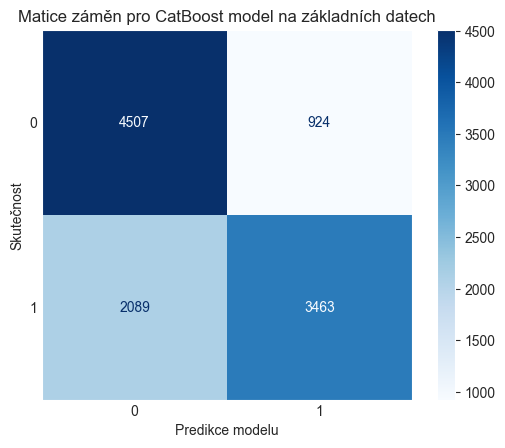

In [16]:
print_metrics(model_with_price, X_test_base, y_test_base, ptitle="Matice záměn pro CatBoost model na základních datech")

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
predictions = model_with_price.predict(X_test_base)
cm_catboost = confusion_matrix(y_test_base.astype("str"), predictions)

In [24]:
importances_simple = model_with_price.get_feature_importance()
feature_importances_simple = pd.Series(importances_simple, index=X_test_base.columns).sort_values(ascending=False)
feature_importances_simple 

type_of_procedure                34.897792
code_from_nipez_codelist         15.980910
public_contract_regime           10.557039
place_of_performance              8.991075
price_vat                         8.117585
type                              7.380310
price                             3.110001
is_association_of_suppliers_x     2.688404
is_withdrawn                      2.553458
is_association_of_suppliers_y     2.545400
bids_submission_deadline          1.720144
date_of_publication               1.338343
is_rejected_due_too_low           0.119539
date_of_contract_close            0.000000
dtype: float64

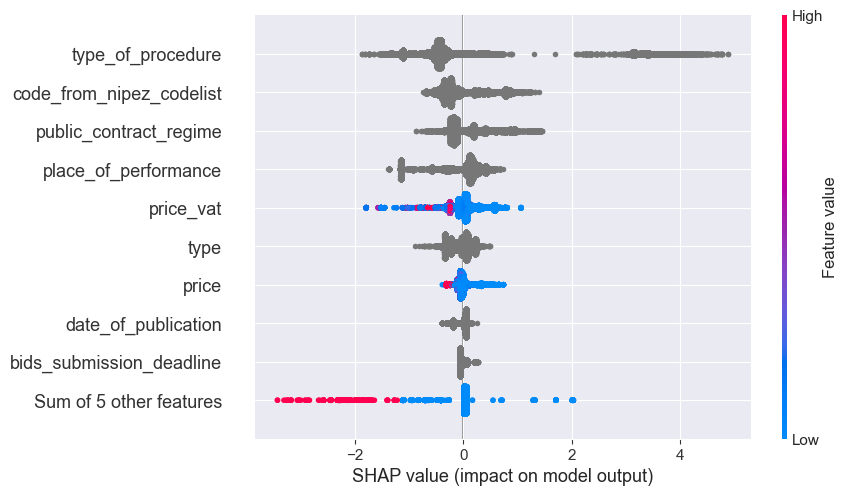

In [25]:
explainer = shap.Explainer(model_with_price)
shap_values = explainer(X_train_base)
plt.close('all')
shap.plots.beeswarm(shap_values)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [27]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_base)
X_train_dummies = enc.transform(X_train_base)

In [28]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_dummies, y_train_base)

In [29]:
X_test_dummies = enc.transform(X_test_base)

Balanced accuracy: 0.7149194081155412
F1 score micro: 0.7141946644814714
F1 score macro: 0.7132330491860157
RocAuc score: 0.7824047309261539
Confusion matrix:


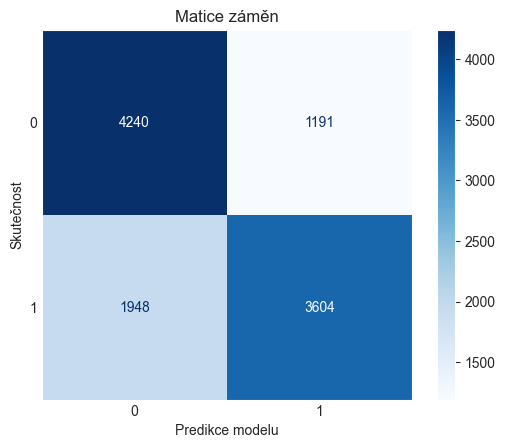

In [30]:
print_metrics(clf, X_test_dummies, y_test_base, retype_pred=True)

In [32]:
predictions = clf.predict(X_test_dummies)
cm_logreg = confusion_matrix(y_test_base, predictions)